Epoch 1/20
78/78 [==============================] - 5s 25ms/step - loss: 0.2199 - mae: 0.5915
Epoch 2/20
78/78 [==============================] - 2s 26ms/step - loss: 0.1296 - mae: 0.4366
Epoch 3/20
78/78 [==============================] - 2s 26ms/step - loss: 0.0643 - mae: 0.2901
Epoch 4/20
78/78 [==============================] - 2s 26ms/step - loss: 0.0350 - mae: 0.2157
Epoch 5/20
78/78 [==============================] - 3s 36ms/step - loss: 0.0235 - mae: 0.1796
Epoch 6/20
78/78 [==============================] - 3s 33ms/step - loss: 0.0191 - mae: 0.1625
Epoch 7/20
78/78 [==============================] - 3s 33ms/step - loss: 0.0170 - mae: 0.1532
Epoch 8/20
78/78 [==============================] - 3s 32ms/step - loss: 0.0158 - mae: 0.1470
Epoch 9/20
78/78 [==============================] - 3s 34ms/step - loss: 0.0150 - mae: 0.1430
Epoch 10/20
78/78 [==============================] - 3s 31ms/step - loss: 0.0144 - mae: 0.1402
Epoch 11/20
78/78 [==============================] - 3s 32m

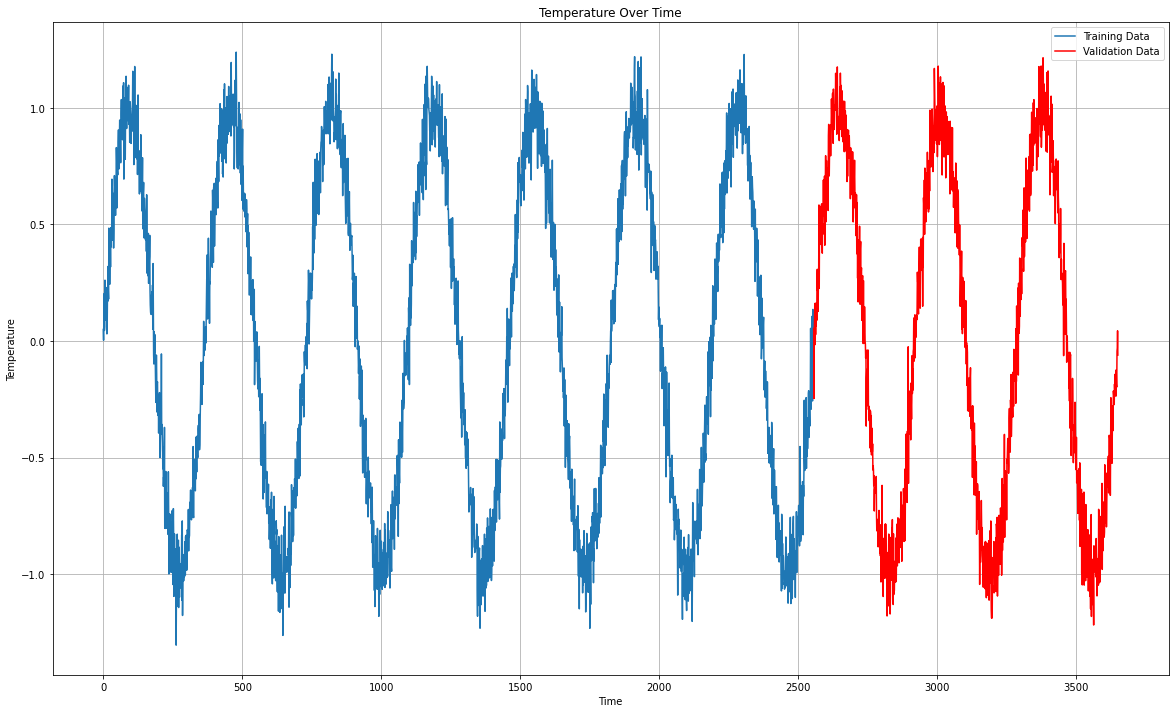

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Assuming temperatures and timestamps are available as NumPy arrays
# For example purposes, let's generate some dummy data
np.random.seed(42)  # For reproducible results
timestamps = np.arange(0, 3650)  # Representing 10 years of daily data
temperatures = np.sin(timestamps * 2 * np.pi / 365) + np.random.normal(0, 0.1, len(timestamps))

# Function to plot a series of data points
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Data class to hold global variables and parsed data
@dataclass
class G:
    TIME = timestamps
    SERIES = temperatures
    SPLIT_TIME = int(len(timestamps) * 0.7)  # 70% for training, 30% for validation
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

# Split dataset into training and validation sets
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# Function to prepare windowed dataset for model training
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_train)

# Model architecture remains the same as in your previous code
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    learning_rate = 5e-4
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])

    return model

model = create_model()
history = model.fit(train_set, epochs=20)

# Forecasting and evaluation functions remain the same
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

mse, mae = compute_metrics(series_valid, rnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

# Split data: 70% for training and 30% for validation
split_time = int(len(timestamps) * 0.7)
time_train, series_train = timestamps[:split_time], temperatures[:split_time]
time_valid, series_valid = timestamps[split_time:], temperatures[split_time:]

# Plot training and validation series
plt.figure(figsize=(20, 12))
plt.plot(time_train, series_train, label='Training Data')
plt.plot(time_valid, series_valid, label='Validation Data', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/20
78/78 [==============================] - 7s 39ms/step - loss: 0.2298 - mae: 0.6071
Epoch 2/20
78/78 [==============================] - 2s 27ms/step - loss: 0.1911 - mae: 0.5518
Epoch 3/20
78/78 [==============================] - 2s 28ms/step - loss: 0.1492 - mae: 0.4836
Epoch 4/20
78/78 [==============================] - 2s 28ms/step - loss: 0.1014 - mae: 0.3913
Epoch 5/20
78/78 [==============================] - 2s 28ms/step - loss: 0.0606 - mae: 0.2944
Epoch 6/20
78/78 [==============================] - 2s 28ms/step - loss: 0.0358 - mae: 0.2252
Epoch 7/20
78/78 [==============================] - 2s 28ms/step - loss: 0.0243 - mae: 0.1859
Epoch 8/20
78/78 [==============================] - 2s 28ms/step - loss: 0.0196 - mae: 0.1659
Epoch 9/20
78/78 [=============================

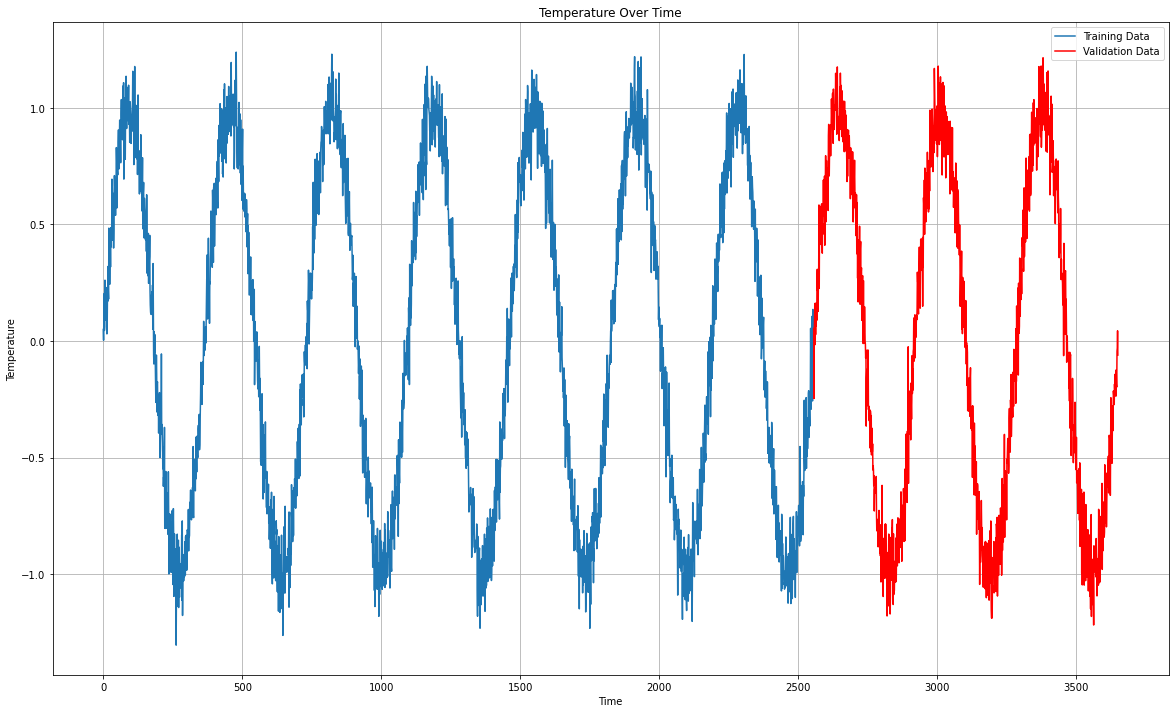

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Assuming temperatures and timestamps are available as NumPy arrays
# For example purposes, let's generate some dummy data
np.random.seed(42)  # For reproducible results
timestamps = np.arange(0, 3650)  # Representing 10 years of daily data
temperatures = np.sin(timestamps * 2 * np.pi / 365) + np.random.normal(0, 0.1, len(timestamps))

# Function to plot a series of data points
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Data class to hold global variables and parsed data
@dataclass
class G:
    TIME = timestamps
    SERIES = temperatures
    SPLIT_TIME = int(len(timestamps) * 0.7)  # 70% for training, 30% for validation
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

# Split dataset into training and validation sets
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# Function to prepare windowed dataset for model training
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_train)

# Model architecture remains the same as in your previous code
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    learning_rate = 5e-4
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])

    return model

model = create_model()
history = model.fit(train_set, epochs=20)

# Forecasting and evaluation functions remain the same
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

mse, mae = compute_metrics(series_valid, rnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

# Split data: 70% for training and 30% for validation
split_time = int(len(timestamps) * 0.7)
time_train, series_train = timestamps[:split_time], temperatures[:split_time]
time_valid, series_valid = timestamps[split_time:], temperatures[split_time:]

# Plot training and validation series
plt.figure(figsize=(20, 12))
plt.plot(time_train, series_train, label='Training Data')
plt.plot(time_valid, series_valid, label='Validation Data', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

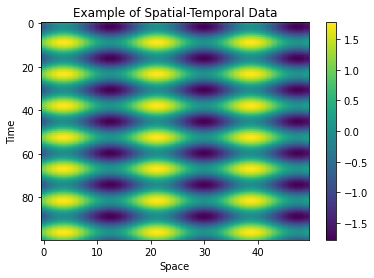

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spatial_temporal_data(num_samples, num_points, time_steps, predicted_snapshots):
    np.random.seed(0)  # Set seed for reproducibility

    # Generate randomized features to vary datasets
    sin_Amp = np.random.uniform(0, 1, num_samples)
    cos_Amp = np.random.uniform(0, 1, num_samples)
    sin_freq = np.random.uniform(0, 1, num_samples)
    cos_freq = np.random.uniform(0, 1, num_samples)
    sin_phase = np.random.uniform(0, 1, num_samples)
    cos_phase = np.random.uniform(0, 1, num_samples)

    # Create training data
    time = np.linspace(0, 10, time_steps)  # time vector
    space = np.linspace(0, 10, num_points)  # space vector

    # Using broadcasting to create the grid of values
    X_train = np.zeros((num_samples, time_steps, num_points))
    for i in range(num_samples):    
        X_train[i, :, :] = sin_Amp[i] * np.sin(2 * np.pi * sin_freq[i] * (time[:, None] - sin_phase[i])) + \
                           cos_Amp[i] * np.cos(2 * np.pi * cos_freq[i] * (space[None, :] - cos_phase[i]))
    return X_train

# Parameters
num_samples = 1000  # number of training samples
num_points = 50     # number of spatial points
time_steps = 100    # number of time snapshots
predicted_snapshots = 10  # number of time snapshots to predict

# Generate data
X_train = generate_spatial_temporal_data(num_samples, num_points, time_steps, predicted_snapshots)

# Example Data Visualization
plt.figure()
plt.imshow(X_train[300], aspect='auto')
plt.colorbar()
plt.title("Example of Spatial-Temporal Data")
plt.xlabel("Space")
plt.ylabel("Time")
plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

def create_model(input_shape, num_predictions):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        LSTM(64, return_sequences=True),
        LSTM(64, return_sequences=False),
        Dense(num_predictions),
        Reshape((predicted_snapshots, num_points))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Since we're predicting future states, re-organize our data
X, Y = X_train[:, :time_steps-predicted_snapshots, :], X_train[:, time_steps-predicted_snapshots:, :]

# Define the input shape and number of predictions
input_shape = (time_steps - predicted_snapshots, num_points)
num_predictions = predicted_snapshots * num_points

# Create and train the model
model = create_model(input_shape, num_predictions)
history = model.fit(X, Y, batch_size=32, epochs=25, validation_split=0.2, verbose=1)

Epoch 1/25
25/25 [==============================] - 4s 64ms/step - loss: 0.3361 - val_loss: 0.3270
Epoch 2/25
25/25 [==============================] - 1s 37ms/step - loss: 0.3017 - val_loss: 0.2892
Epoch 3/25
25/25 [==============================] - 1s 35ms/step - loss: 0.2659 - val_loss: 0.2618
Epoch 4/25
25/25 [==============================] - 1s 36ms/step - loss: 0.2352 - val_loss: 0.2403
Epoch 5/25
25/25 [==============================] - 1s 34ms/step - loss: 0.2063 - val_loss: 0.2247
Epoch 6/25
25/25 [==============================] - 1s 34ms/step - loss: 0.1760 - val_loss: 0.2036
Epoch 7/25
25/25 [==============================] - 1s 34ms/step - loss: 0.1532 - val_loss: 0.1941
Epoch 8/25
25/25 [==============================] - 1s 34ms/step - loss: 0.1312 - val_loss: 0.1648
Epoch 9/25
25/25 [==============================] - 1s 34ms/step - loss: 0.1122 - val_loss: 0.1436
Epoch 10/25
25/25 [==============================] - 1s 34ms/step - loss: 0.0972 - val_loss: 0.1422
Epoch 11/

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
        input_shape=input_shape,
        padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LSTM(
        hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        return_sequences=True))
    model.add(layers.LSTM(
        hp.Int('lstm_units_2', min_value=32, max_value=128, step=32),
        return_sequences=False))
    model.add(layers.Dense(num_predictions))
    model.add(layers.Reshape((predicted_snapshots, num_points)))
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Set to a reasonable number to explore a few combinations
    executions_per_trial=1,  # Number of models that should be built and fit for each trial
    directory='store_best_model',  # Directory to store the tuning logs
    project_name='spatio_temporal_model'
)

tuner.search(X, Y, epochs=20, validation_split=0.2, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Best model hyperparameters:', best_hyperparameters.values)

Trial 10 Complete [00h 00m 21s]
val_loss: 0.07794541120529175

Best val_loss So Far: 0.05462266504764557
Total elapsed time: 00h 05m 54s
Best model hyperparameters: {'filters': 64, 'lstm_units': 128, 'lstm_units_2': 96, 'learning_rate': 0.001}


In [37]:
def generate_test_data(num_samples, time_steps, num_points):
    np.random.seed(1)  # Use a different seed for test data

    # Generate randomized features for the second dataset
    sin_Amp_test = np.random.uniform(0, 1, num_samples)
    cos_Amp_test = np.random.uniform(0, 1, num_samples)
    sin_freq_test = np.random.uniform(0, 1, num_samples)
    cos_freq_test = np.random.uniform(0, 1, num_samples)
    sin_phase_test = np.random.uniform(0, 1, num_samples)
    cos_phase_test = np.random.uniform(0, 1, num_samples)

    # Create the second dataset (X_test)
    X_test = np.zeros((num_samples, time_steps, num_points))
    for i in range(num_samples):
        X_test[i, :, :] = sin_Amp_test[i] * np.sin(2 * np.pi * sin_freq_test[i] * (time[:, None] - sin_phase_test[i])) + \
                          cos_Amp_test[i] * np.cos(2 * np.pi * cos_freq_test[i] * (space[None, :] - cos_phase_test[i]))
    return X_test

# Generate test data
X_test = generate_test_data(num_samples, time_steps, num_points)
Y_test = X_test[:, time_steps-predicted_snapshots:, :]

In [45]:
# Prepare the test data for prediction
X_test_input = X_test[:, :time_steps-predicted_snapshots, :]

# Generate predictions
Y_test_pred = model.predict(X_test_input)

# Get test loss
test_loss = best_model.evaluate(X_test_adjusted, Y_test, verbose=1)
print(f"Test Loss: {test_loss}")

32/32 [==============================] - 1s 24ms/step - loss: 0.0546
Test Loss: 0.05461481958627701


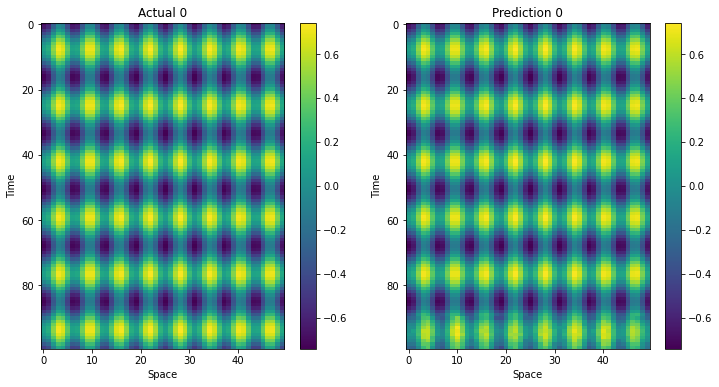

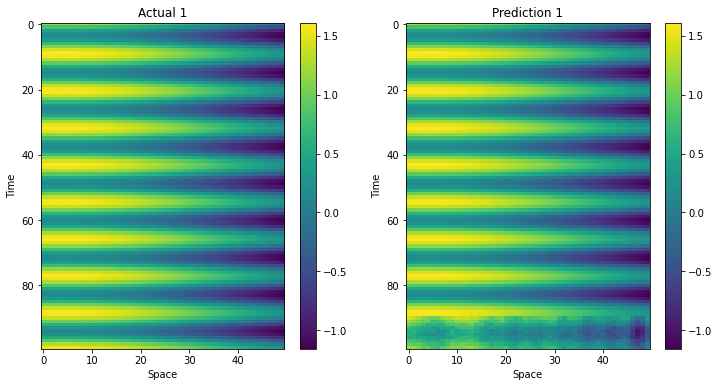

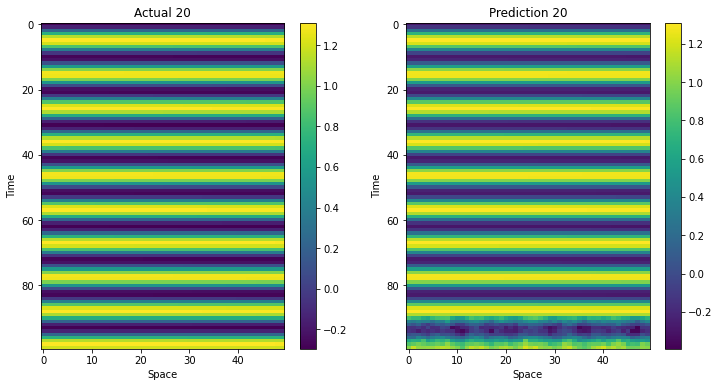

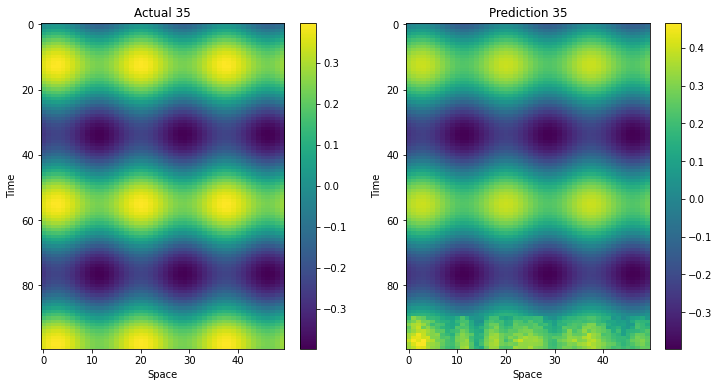

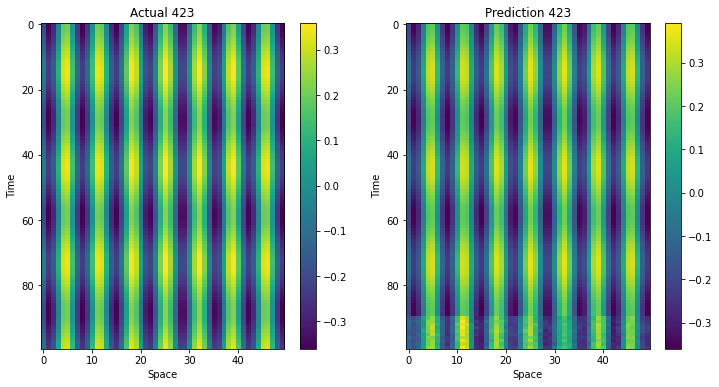

In [44]:
# Visualize predictions for specified indices
indices_to_visualize = [0, 1, 20, 35, 423]  # Example indices for which predictions will be visualized
visualize_predictions(X_test, Y_test_pred, indices_to_visualize, time_steps, predicted_snapshots, num_points)

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

import sys
# Add the path to the directory containing fields.py if it's not in the same directory as the notebook
sys.path.append('C:\\Users\\chris\\1DNumericalPDE\\MSU Extension\\OOP')
from fields import generate_simulated_data

# Parameters for data generation
num_samples = 1000
num_points = 50
time_steps = 100

# Generate data
simulated_data = generate_simulated_data(num_samples, num_points, time_steps)

# Function to generate spatial-temporal data
def generate_spatial_temporal_data(num_samples, num_points, time_steps, predicted_snapshots, num_channels=3, seed=0):
    np.random.seed(seed)
    # Parameters for generating sinusoidal patterns
    sin_Amp, cos_Amp = np.random.uniform(0, 1, (2, num_samples, num_channels))
    sin_freq, cos_freq = np.random.uniform(0.5, 1.5, (2, num_samples, num_channels))  # Slightly adjust frequency ranges
    sin_phase, cos_phase = np.random.uniform(0, 2*np.pi, (2, num_samples, num_channels))
    
    time = np.linspace(0, 10, time_steps)
    space = np.linspace(0, 10, num_points)
    
    # Generate data using broadcasting, iterating over each channel
    X = np.zeros((num_samples, num_channels, time_steps, num_points))
    for i in range(num_channels):
        sin_component = sin_Amp[:, i, None, None] * np.sin(2 * np.pi * sin_freq[:, i, None, None] * (time[None, None, :, None] - sin_phase[:, i, None, None]))
        cos_component = cos_Amp[:, i, None, None] * np.cos(2 * np.pi * cos_freq[:, i, None, None] * (space[None, None, None, :] - cos_phase[:, i, None, None]))
        X[:, i, :, :] = sin_component + cos_component
    
    return X

# Parameters
num_samples, num_points, time_steps, predicted_snapshots, num_channels = 1000, 50, 100, 10, 3
X_train = generate_spatial_temporal_data(num_samples, num_points, time_steps, predicted_snapshots, num_channels)
X_test = generate_spatial_temporal_data(num_samples, num_points, time_steps, predicted_snapshots, num_channels, seed=1)
Y_test = X_test[:, :, time_steps-predicted_snapshots:, :]

# Reshape for the neural network: The neural network expects an input shape of
# (batch_size, time_steps, num_points, num_channels)
X_train = np.transpose(X_train, (0, 2, 3, 1))
X_test = np.transpose(X_test, (0, 2, 3, 1))
Y_test = np.transpose(Y_test, (0, 2, 3, 1))

# Check shapes for sanity
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

# Prepare the input (X) and labels (Y) for the neural network
X = X_train[:, :time_steps-predicted_snapshots, :, :]
Y = Y_test

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# Define the model with hyperparameters using Keras Tuner
def build_model(hp):
    model = keras.Sequential([
        layers.Conv2D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3), activation='relu',
            input_shape=(time_steps - predicted_snapshots, num_points, num_channels),  # Notice channels_last
            padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Reshape((time_steps - predicted_snapshots, -1)),  # Reshape to (seq_length, features) for LSTM
        layers.LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=True),
        layers.LSTM(hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)),
        layers.Dense(predicted_snapshots * num_points * num_channels),
        layers.Reshape((predicted_snapshots, num_points, num_channels))
    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='mse')
    return model

# Hyperparameter tuning
tuner = RandomSearch(build_model, objective='val_loss', max_trials=10, executions_per_trial=1,
    directory='store_best_model',
    project_name='spatio_temporal_model_3D'
)

# Early stopping to prevent overfitting
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(
    X, Y,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping_callback],
    verbose=1
)

Shape of X_train: (1000, 100, 50, 3)
Shape of X_test: (1000, 100, 50, 3)
Shape of Y_test: (1000, 10, 50, 3)
Shape of X: (1000, 90, 50, 3)
Shape of Y: (1000, 10, 50, 3)
Reloading Tuner from store_best_model\spatio_temporal_model_3D\tuner0.json
32/32 [==============================] - 15s 462ms/step - loss: 0.3059
Test Loss: 0.305896520614624


In [85]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluation on test data
X_test_adjusted = X_test[:, :time_steps-predicted_snapshots, :, :]

# Assuming X_test_adjusted is already prepared
Y_test_pred = best_model.predict(X_test_adjusted)
print("Prediction Shape:", Y_test_pred.shape)

# Evaluate the model
test_loss = best_model.evaluate(X_test_adjusted, Y_test, verbose=1)
print(f"Test Loss: {test_loss}")

32/32 [==============================] - 17s 501ms/step
Prediction Shape: (1000, 10, 50, 3)
32/32 [==============================] - 19s 585ms/step - loss: 0.3059
Test Loss: 0.305896520614624


In [86]:
indices = [0]

# Check shapes for sanity
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

# Prepare the input (X) and labels (Y) for the neural network
X = X_train[:, :time_steps-predicted_snapshots, :, :]
Y = Y_test

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# Other
print(X_test.shape)
print(Y_test_pred.shape)

Shape of X_train: (1000, 100, 50, 3)
Shape of X_test: (1000, 100, 50, 3)
Shape of Y_test: (1000, 10, 50, 3)
Shape of X: (1000, 90, 50, 3)
Shape of Y: (1000, 10, 50, 3)
(1000, 100, 50, 3)
(1000, 10, 50, 3)


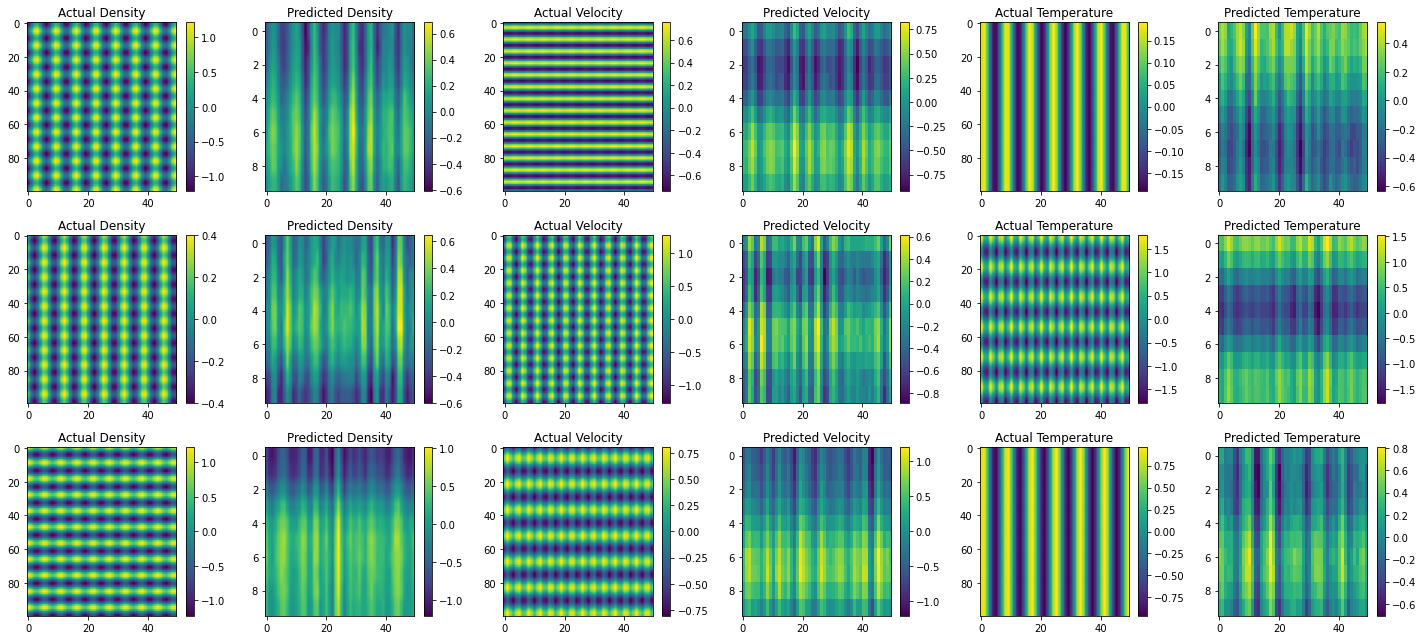

In [90]:
def visualize_comparisons(X_test, Y_test, Y_test_pred, indices, channel_names=["Density", "Velocity", "Temperature"]):
    num_channels = len(channel_names)
    num_samples = len(indices)
    fig, axes = plt.subplots(num_samples, num_channels*2, figsize=(20, num_samples*3))
    
    for idx, sample_index in enumerate(indices):
        for channel_index in range(num_channels):
            # Actual
            ax = axes[idx, channel_index*2]
            actual = X_test[sample_index, :, :, channel_index]
            im = ax.imshow(actual, aspect='auto')
            ax.set_title(f'Actual {channel_names[channel_index]}')
            plt.colorbar(im, ax=ax)
            
            # Prediction
            ax = axes[idx, channel_index*2 + 1]
            prediction = Y_test_pred[sample_index, :, :, channel_index]
            im = ax.imshow(prediction, aspect='auto')
            ax.set_title(f'Predicted {channel_names[channel_index]}')
            plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

# Select some indices to visualize
indices_to_visualize = [0, 10, 32]

# Assuming Y_test_pred has been reshaped correctly as per previous steps
visualize_comparisons(X_test, Y_test, Y_test_pred, indices_to_visualize)
